Load needed libraries

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import box,mapping

STEP B: 
Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}  

Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In [ ]:
scene_paths = ["m1.png","m2.png","m3.png","m4.png","m5.png"]
model_paths = ["0.jpg","1.jpg","11.jpg","19.jpg","24.jpg","26.jpg","25.jpg"]


def load_images(paths,dir):
  return [cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/CV Project/"+dir+path),cv2.COLOR_BGR2RGB) for path in paths]
  
# Load scene and model images
train_images = load_images(scene_paths,"scenes/")
query_images = load_images(model_paths,"models/")

# Compute keypoints and descriptors
sift = cv2.SIFT_create()

train_features = {index:sift.detectAndCompute(train_image,None) for index,train_image in enumerate(train_images)}
query_features = {index:sift.detectAndCompute(query_image,None) for index,query_image in enumerate(query_images)}

In [ ]:
def compute_matches(FLANN_INDEX_KDTREE,trees,checks,k,lowe,des_query,des_train):
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = trees)
  search_params = dict(checks = checks)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des_train,des_query,k=2)
  # store all the good matches as per Lowe's ratio test.
  good = []
  for m,n in matches:
      if m.distance < lowe*n.distance:
          good.append(m)
  return good

# Get the dominant color in the image with Kmeans clustering
def get_dom_color(img_in):
  Z = img_in.reshape((-1,3))
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 1
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((img_in.shape))
  return res2[0][0]

def get_roi(x1,x2,x3,x4,y1,y2,y3,y4,img):
  top_left_x = int(max(0,min([x1,x2,x3,x4])))
  top_left_y = int(max(0, min([y1,y2,y3,y4])))
  bot_right_x = int(max([x1,x2,x3,x4]))
  bot_right_y = int(max([y1,y2,y3,y4]))
  return (img[top_left_y:bot_right_y, top_left_x:bot_right_x],(top_left_x,top_left_y),(bot_right_x,bot_right_y))

def cluster_kp(keypoints, quantile = 0.10):
      x = np.array([keypoint.pt[0] for keypoint in keypoints]).reshape(-1,1) 
      bandwidth = estimate_bandwidth(x, quantile= quantile)
      ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
      ms.fit(x)
      return ms.labels_, len(np.unique(ms.labels_))

def bb_intersection_over_union(rectangleA, rectangleB):
      intersection = rectangleA.intersection(rectangleB).area
      union = rectangleA.union(rectangleB).area
      if intersection and union:
        return intersection / union
      else:
        return 0

def non_maxima_suppression(rectangles, IOU_THRES = 0.3):
  polygons = [box(start[0], start[1], end[0],end[1]) for start,end in rectangles]
  maxima = []
  polygons.sort(key=lambda x: x.area, reverse=True)
  while polygons:
    rectA = polygons.pop(0)
    maxima.append(rectA)
    for rectB in polygons:
      if bb_intersection_over_union(rectA,rectB) >= IOU_THRES:
        polygons.remove(rectB)
        
  return maxima

# Print the output and draw the bounding box and centroids
def print_output(query_idx,rectangles,img_train):
    print("Product {} - {} Instances Found:".format(query_idx,len(rectangles)))
    for index in range(len(rectangles)):
        centroid = rectangles[index].centroid
        bounding_box = mapping(rectangles[index])["coordinates"]
        width = int(bounding_box[0][1][0]) - int(bounding_box[0][3][0])
        height = int(bounding_box[0][1][1]) - int(bounding_box[0][3][1])
        cv2.rectangle(img_train, (int(bounding_box[0][3][0]),int(bounding_box[0][3][1])), (int(bounding_box[0][1][0]),int(bounding_box[0][1][1])), (0,255,0), thickness = 5)
        cv2.circle(img_train, (int(centroid.xy[0][0]),int(centroid.xy[1][0])), radius=5, color=(0, 255, 0), thickness=-1)
        print("Instance {} [ position: (({},{}), width: {} px, height: {} px]".format(query_idx,centroid.xy[0][0],centroid.xy[1][0],width,height))

    return len(rectangles)


Product 4 - 2 Instances Found:
Instance 4 [ position: ((186.5,233.5), width: 365 px, height: 467 px]
Instance 4 [ position: ((550.0,234.5), width: 340 px, height: 469 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((928.5,230.5), width: 355 px, height: 461 px]
Product 6 - 1 Instances Found:
Instance 6 [ position: ((1259.5,232.5), width: 325 px, height: 449 px]


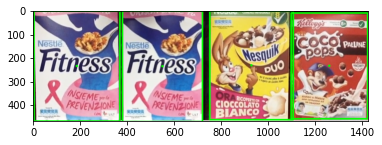

Product 0 - 1 Instances Found:
Instance 0 [ position: ((178.0,302.5), width: 348 px, height: 463 px]
Product 1 - 2 Instances Found:
Instance 1 [ position: ((1178.0,265.5), width: 312 px, height: 423 px]
Instance 1 [ position: ((850.0,256.0), width: 316 px, height: 414 px]
Product 2 - 1 Instances Found:
Instance 2 [ position: ((520.0,263.0), width: 328 px, height: 420 px]


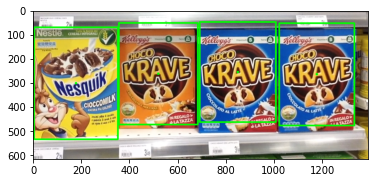

Product 3 - 1 Instances Found:
Instance 3 [ position: ((1232.0,190.5), width: 300 px, height: 381 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((192.0,230.5), width: 364 px, height: 461 px]
Product 6 - 2 Instances Found:
Instance 6 [ position: ((557.5,229.5), width: 341 px, height: 459 px]
Instance 6 [ position: ((887.5,225.5), width: 329 px, height: 447 px]


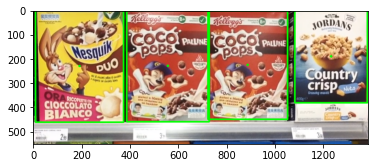

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Product 4 - 2 Instances Found:
Instance 4 [ position: ((538.0,223.0), width: 360 px, height: 446 px]
Instance 4 [ position: ((175.5,224.0), width: 351 px, height: 448 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((920.5,222.0), width: 345 px, height: 444 px]
Product 6 - 2 Instances Found:
Instance 6 [ position: ((1269.0,217.0), width: 332 px, height: 434 px]
Instance 6 [ position: ((1587.5,214.0), width: 319 px, height: 428 px]


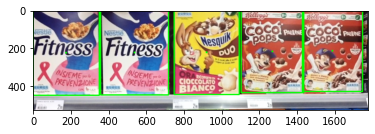

Product 1 - 2 Instances Found:
Instance 1 [ position: ((503.0,718.0), width: 320 px, height: 414 px]
Instance 1 [ position: ((833.0,720.0), width: 306 px, height: 422 px]
Product 2 - 1 Instances Found:
Instance 2 [ position: ((164.0,714.0), width: 312 px, height: 404 px]
Product 3 - 1 Instances Found:
Instance 3 [ position: ((908.0,191.5), width: 300 px, height: 383 px]
Product 6 - 2 Instances Found:
Instance 6 [ position: ((236.0,228.0), width: 340 px, height: 456 px]
Instance 6 [ position: ((564.0,231.5), width: 330 px, height: 457 px]


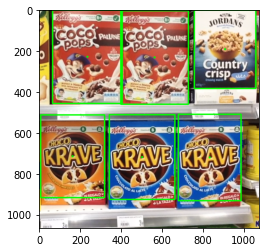

True


In [ ]:
def object_retrieve(query_idx,img_query, img_train, query_features, train_features, min_match_count = 50, COLOR_DIFF_THRESHOLD = 45, verbose = False):
    rectangles = []
    # Partition the keypoints of train image into clusters
    labels,n_clusters = cluster_kp(train_features[0])
    # We analyze each cluster 
    for i in range(n_clusters):
      # Compute the matches on the subset of keypoints
      key_train_local = np.array(train_features[0])[labels == i]
      des_train_local = np.array(train_features[1])[labels == i]
      good = compute_matches(0,5,50,2,0.55,des_train_local,query_features[1])
      # If it's a good match, then proceed with the detection
      if len(good)>min_match_count:
          src_pts = np.float32([query_features[0][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([key_train_local[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)
          if M is None:
              print ("No Homography was found")
          else:
              h,w,_ = img_query.shape
              # Generate and plot the rectangle into the target image
              pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
              dst = cv2.perspectiveTransform(pts,M)
              roi,start,end = get_roi(dst[0][0][0],dst[1][0][0],dst[2][0][0],dst[3][0][0],dst[0][0][1],dst[1][0][1],dst[2][0][1],dst[3][0][1],img_train)
              # If we can manage to obtain a rectangle, then we proceed
              if len(roi):
                # check if the euclidean distance between the colors (mean) of the two rectangle is lower than the chosen threshold
                color_diff = np.linalg.norm(roi.mean(axis = 0).mean(axis = 0) - img_query.mean(axis = 0).mean(axis = 0))           
                if color_diff <= COLOR_DIFF_THRESHOLD:
                    plt.show()
                    rectangles.append((start,end))
    
    # If there were multiple detection for the same roi, we discard them with non maxima suppression
    rectangles = non_maxima_suppression(rectangles)

    # Draw the bounding box and center pixel of every blob
    if len(rectangles):
      print_output(query_idx,rectangles,img_train)

    return len(rectangles)



pred_labels = {}
#Iterating among all scenes and looking for the query object.
for index_train in range(len(train_images)):
  scene_labels = []
  for index_query in range(len(query_images)):
    scene_labels.append(object_retrieve(index_query,query_images[index_query], train_images[index_train], query_features[index_query], train_features[index_train]))
  imgplot = plt.imshow(train_images[index_train])
  plt.show()
  pred_labels[index_train] = scene_labels

true_labels = {
    0: [0,0,0,0,2,1,1],
    1: [1,2,1,0,0,0,0],
    2: [0,0,0,1,0,1,2],
    3: [0,0,0,0,2,1,2],
    4: [0,2,1,1,0,0,2],
}
print(true_labels == pred_labels)